<a href="https://colab.research.google.com/github/kshitijmamgain/NLP/blob/master/Text_Analysis_using_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Sentiment Analysis
We have labled data set of 10000 reviews on books, songs, movies
 and other stuff. In NLP there are great tools to effectively extract the information from such unstructured texts.
To implement we shall first call all the relevant packages.

STEP -1: Importing Packages <br>
Below are the list of packageswhich would be used for text processing. I generally put them together in final program to make codes look neat.

In [1]:
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
np.random.seed(500)

STEP -2: Setting Google Colab <br>
Google Colab ofers us tremendous computing speed on its spare CPUs. You can save the data on your google drive and access it in colab. Below codes would provide us access to dataset after we authorize Google.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
Corpus = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/1578771807_corpus.csv",encoding='latin-1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
print(Corpus.shape)
Corpus.head(5)

(10000, 2)


,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


#### Step -3: Data Exploration
After successfully loading the data we would invest some time to explore the dataset

In [5]:
Corpus.describe()

,text,label
count,10000,10000
unique,10000,2
top,Neat package but very grainy indoor quality: ...,__label__1
freq,1,5097


Text(0.5, 1.0, 'Sentiment Count')

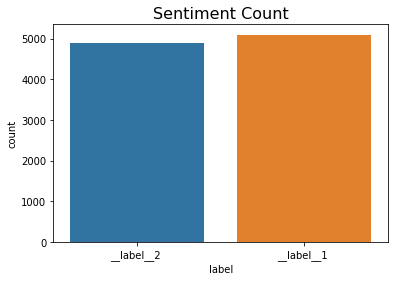

In [6]:
sns.countplot(Corpus['label'])
plt.title("Sentiment Count", size = 16)

We observe that the 10000 reviews are all unique but wre identified positive and negative by label 1 and label 2. We also see that the dataset is balanced and has almost equal number of reviews in positive and negative. Let us now proceed to text pre-processing.

##### STEP -4: Data pre-processing
This is an important step in any data mining process. 
This basically involves transforming raw data into an understandable format for NLP models. Real-world data is often incomplete, inconsistent, and/or lacking in certain behaviors or trends, and is likely to contain many errors. Data pre-processing is a proven method of resolving such issues.This will help in getting better results through the classification algorithms.

Below, I have explained the two techniques that are also performed besides other easy to understand steps in data pre-processing:

######  Tokenization: 


This is a process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing. NLTK Library has word_tokenize and sent_tokenize to easily break a stream of text into a list of words or sentences, respectively.


###### Word Stemming/Lemmatization: 


The aim of both processes is the same, reducing the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.


Here’s the complete script which performs the aforementioned data pre-processing steps, you can always add or remove steps which best suits the data set you are dealing with:

* Remove Blank rows in Data, if any
* Change all the text to lower case
* Word Tokenization
* Remove Stop words
* Remove Non-alpha text
* Word Lemmatization


In [7]:
# Step - a : Remove blank rows if any.
Corpus.dropna(axis = 0, how = 'any', inplace = True)

# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [str.lower(txt) for txt in Corpus['text']]

# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text'] = [word_tokenize(txt) for txt in Corpus['text']]

Corpus.head(3)

,text,label
0,"[stuning, even, for, the, non-gamer, :, this, ...",__label__2
1,"[the, best, soundtrack, ever, to, anything, .,...",__label__2
2,"[amazing, !, :, this, soundtrack, is, my, favo...",__label__2


We see that word_tokenize package from nltk has seperated the text into list of words. It also seperated punctuations

In [9]:
# Step - d1 : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
"""
1. to remove stop words the words should not be in stopwords.words('english)
2. to allow only non-numeric .isalpha()
def remove_stopwrds(series):
  txt_series = series.copy()
  for i in range(txt_series.shape[0]):
    tst1 = []
    for word in txt_series.iloc[i]:
        if (word not in stopwords.words('english')) & (word.isalpha()):
            tst1.append(word)
        txt_series.iloc[i] = tst1
  return(txt_series)

"""

#defining a new column with out stop words

Corpus['stp_text'] = Corpus['text'].apply(lambda x: [word for word in x if (word not in stopwords.words('english'))& (word.isalpha())])

Corpus.head()

,text,label,stp_text
0,"[stuning, even, for, the, non-gamer, :, this, ...",__label__2,"[stuning, even, sound, track, beautiful, paint..."
1,"[the, best, soundtrack, ever, to, anything, .,...",__label__2,"[best, soundtrack, ever, anything, reading, lo..."
2,"[amazing, !, :, this, soundtrack, is, my, favo...",__label__2,"[amazing, soundtrack, favorite, music, time, h..."
3,"[excellent, soundtrack, :, i, truly, like, thi...",__label__2,"[excellent, soundtrack, truly, like, soundtrac..."
4,"[remember, ,, pull, your, jaw, off, the, floor...",__label__2,"[remember, pull, jaw, floor, hearing, played, ..."


In [0]:
#Step - d2
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
"""
1. pos tag function
2. Define a function for lemmatizing
"""
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

def word_lemmatizer(series):
  """lemmatizes words in series to their root using POS tag"""
  
  count = series.shape[0] # number of inputs
  txt_series = series.copy()
  lemmatizer = WordNetLemmatizer() # initializing lemmatizer
  
  for i in range(count):
    tst = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in txt_series.iloc[i]]
    txt_series.iloc[i] = tst
  
  return(txt_series)

# a new column with lemmatized words
Corpus['lem_txt'] = word_lemmatizer(Corpus['stp_text'])

In [11]:
Corpus.tail(10)

,text,label,stp_text,lem_txt
9990,"[psychological, thriller, !, :, this, movie, r...",__label__2,"[psychological, thriller, movie, really, scare...","[psychological, thriller, movie, really, scar,..."
9991,"[a, little, more, money, than, what, i, expect...",__label__2,"[little, money, expected, spend, good, movie, ...","[little, money, expect, spend, good, movie, hu..."
9992,"[``, the, silence, of, the, dummies, '', :, th...",__label__1,"[silence, dummies, overall, real, hoot, anthon...","[silence, dummy, overall, real, hoot, anthony,..."
9993,"[mauled, again, -, killing, bears, to, enrich,...",__label__1,"[mauled, killing, bears, enrich, jim, cole, ti...","[maul, kill, bear, enrich, jim, cole, ticket, ..."
9994,"[sorry, jim, :, as, a, former, realtor, ,, mr....",__label__1,"[sorry, jim, former, realtor, cole, owes, natu...","[sorry, jim, former, realtor, cole, owes, natu..."
9995,"[a, revelation, of, life, in, small, town, ame...",__label__2,"[revelation, life, small, town, america, early...","[revelation, life, small, town, america, early..."
9996,"[great, biography, of, a, very, interesting, j...",__label__2,"[great, biography, interesting, journalist, bi...","[great, biography, interest, journalist, biogr..."
9997,"[interesting, subject, ;, poor, presentation, ...",__label__1,"[interesting, subject, poor, presentation, tel...","[interest, subject, poor, presentation, tell, ..."
9998,"[do, n't, buy, :, the, box, looked, used, and,...",__label__1,"[buy, box, looked, used, obviously, new, tried...","[buy, box, look, use, obviously, new, try, con..."
9999,"[beautiful, pen, and, fast, delivery, ., :, th...",__label__2,"[beautiful, pen, fast, delivery, pen, shipped,...","[beautiful, pen, fast, delivery, pen, ship, pr..."


In [12]:
#The above dataframe gives us the list of final text but for TF-IDF we need the input as string. So we can create a final column with lambda function
Corpus['text_final'] = Corpus['lem_txt'].apply(lambda x: ' '.join(x))
Corpus['text_final']

0       stun even sound track beautiful paint senery m...
1       best soundtrack ever anything reading lot revi...
2       amaze soundtrack favorite music time hand inte...
3       excellent soundtrack truly like soundtrack enj...
4       remember pull jaw floor hearing played game kn...
                              ...                        
9995    revelation life small town america early thoug...
9996    great biography interest journalist biography ...
9997    interest subject poor presentation tell boring...
9998    buy box look use obviously new try contact ema...
9999    beautiful pen fast delivery pen ship promptly ...
Name: text_final, Length: 10000, dtype: object

##### Prepare Test/ Train/ Datasets

In [0]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=1/5)

##### STEP -6: Encoding
Label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

In [0]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [18]:
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
Train_X.head()

6335    great game game everyone play great storyline ...
7835    broke work well month broke mechanism turn war...
7668    copyright reading single saudi complete work f...
8260    first part bought book day ago test day give s...
8328    lovely saw beth water perform slims san franci...
Name: text_final, dtype: object

In [22]:
Train_X_Tfidf

<8000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 248992 stored elements in Compressed Sparse Row format>

##### STEP -7: Use the ML Algorithms

In [23]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(Train_X_Tfidf,Train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
predictions_LR = LR.predict(Test_X_Tfidf)
print("LR Accuracy Score -> ",accuracy_score(predictions_LR, Test_Y)*100)


LR Accuracy Score ->  85.65


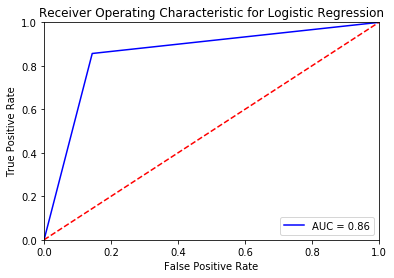

In [39]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = LR.predict_proba(Test_X_Tfidf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Test_Y, predictions_LR)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic Regression is the base prediction model which has performed well with the processed data. Now let us see the performance with __Support Vector Machine__

In [0]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)


In [26]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)


SVM Accuracy Score ->  85.8


In [55]:
from catboost import CatBoostClassifier
CB = CatBoostClassifier( 
                           task_type="GPU",
                           devices='0:1',
                        custom_loss=['Accuracy'])
CB.fit(Train_X_Tfidf,Train_Y,
        eval_set=(Test_X_Tfidf, Test_Y),
  #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True,
        verbose = False);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
predictions_CB = CB.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("CB Accuracy Score -> ",accuracy_score(predictions_CB, Test_Y)*100)

CB Accuracy Score ->  83.1


#Results
We observe that SVM has performed a little better than the base model. Let us see the model summary. We would see the:
  - Cross Validation Score
  - Confusion Matrix


In [0]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(SVM, Train_X_Tfidf,Train_Y, cv=5)


In [32]:
cv_results['test_score']

array([0.84    , 0.848125, 0.83875 , 0.8525  , 0.85375 ])

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Results for SVM Classifier")
print("Accuracy Score : ",accuracy_score(predictions_SVM, Test_Y),"\n\n")

print(pd.DataFrame(confusion_matrix( Test_Y, predictions_SVM)))

print(classification_report( Test_Y, predictions_SVM))

Results for SVM Classifier
Accuracy Score :  0.858 


     0    1
0  886  150
1  134  830
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1036
           1       0.85      0.86      0.85       964

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [48]:
print("Results for CatBoost Classifier")
print("Accuracy Score : ",accuracy_score(predictions_CB, Test_Y),"\n\n")

print(pd.DataFrame(confusion_matrix( Test_Y, predictions_CB)))

print(classification_report( Test_Y, predictions_CB))

Results for CatBoost Classifier
Accuracy Score :  0.8315 


     0    1
0  861  175
1  162  802
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1036
           1       0.82      0.83      0.83       964

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



__Conclusion:__ In this project we compared performance of Logit, SVM and CatBoost Classifier. We see that how effective is Support Vector as a sentiment classifier

# Visualizing NLP with Wordcloud

Wordcloud package offers different ways to create the word cloud, let us explore this analysis package.<br>
__Visualization for negative labels__

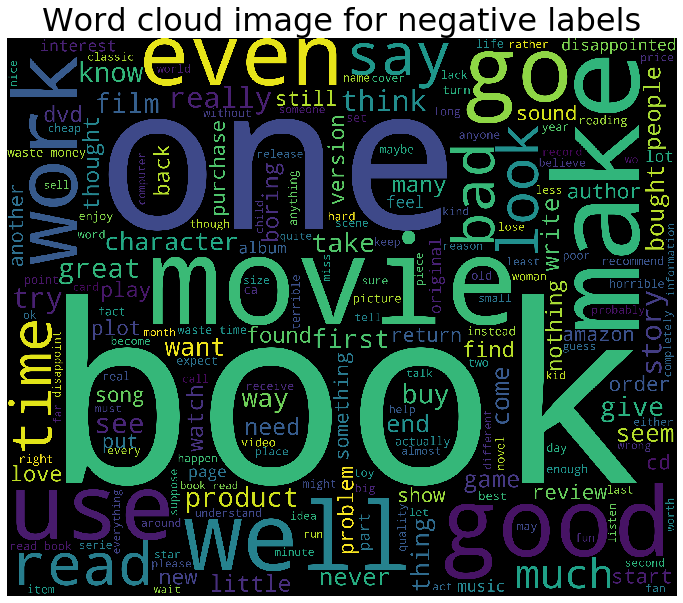

In [50]:
# Way to create image from simple word count
from wordcloud import WordCloud, STOPWORDS
words = ' '.join(Corpus[Corpus['label'] =='__label__1 ']['text_final'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
                     
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.title("Word cloud image for negative labels", size = 32)
plt.axis('off')
plt.show()

In [0]:
Tfidf_L = TfidfVectorizer(max_features=1000)
Tfidf_L.fit(Corpus['text_final'])
print(Tfidf_L.vocabulary_)

In [0]:
# Using TfiDF frequency
# We could use vocabulary from model to get the term frequency inverse document frequency
from wordcloud import WordCloud, STOPWORDS
words = ' '.join(Corpus[Corpus['label'] =='__label__1 ']['text_final'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(Tfidf_L.vocabulary_)

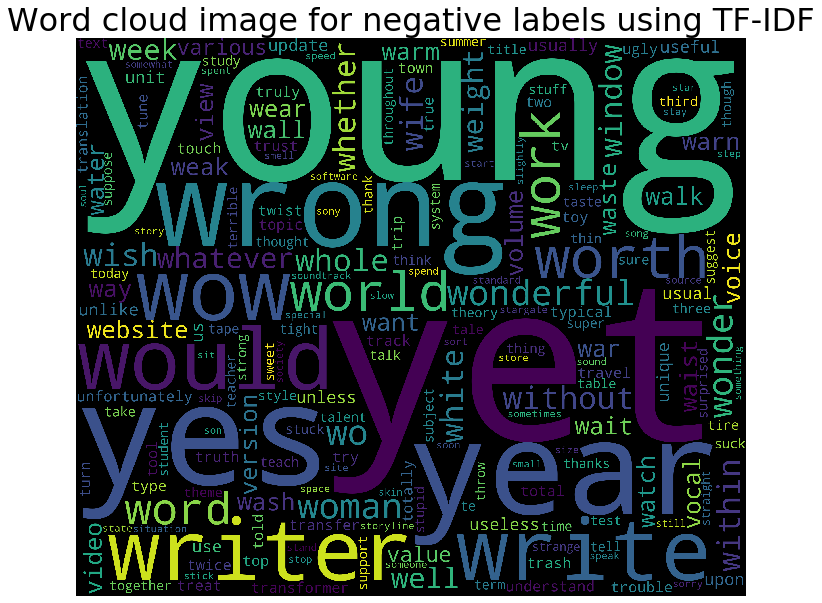

In [58]:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.title("Word cloud image for negative labels using TF-IDF", size = 32)
plt.axis('off')
plt.show()

In [0]:
import multidict as multidict
import re
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|yes|young|yet|would", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict
getFrequencyDictForText(words)

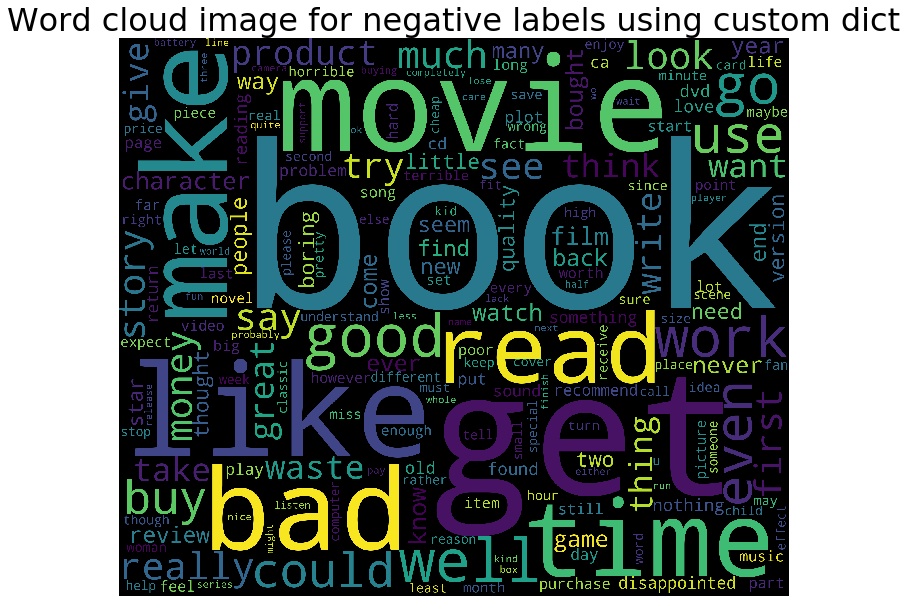

In [63]:

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(getFrequencyDictForText(words))
# Using multidict
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.title("Word cloud image for negative labels using custom dict", size = 32)
plt.axis('off')
plt.show()


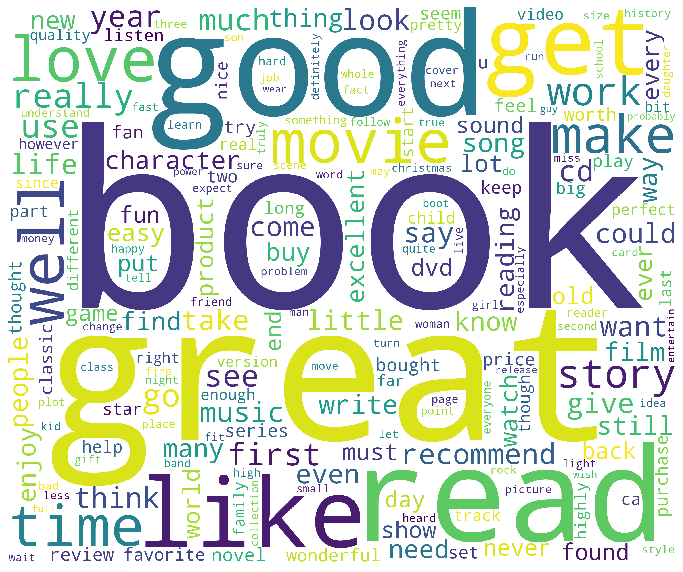

In [64]:
words = ' '.join(Corpus[Corpus['label'] =='__label__2 ']['text_final'])
wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(getFrequencyDictForText(words))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

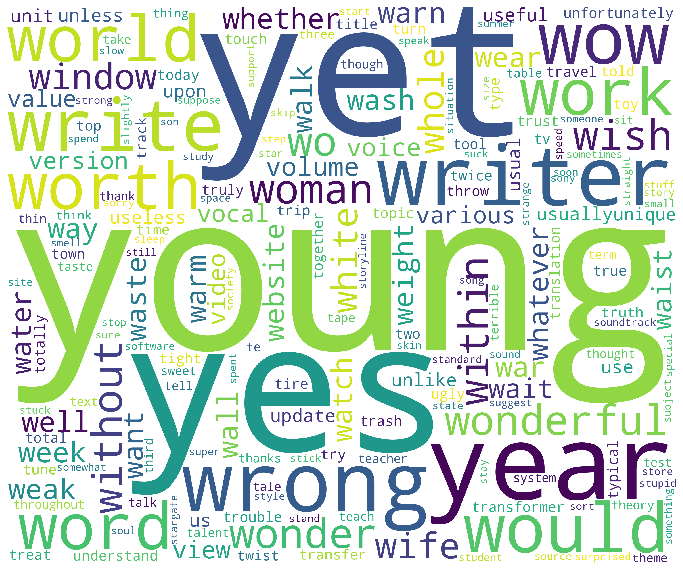

In [65]:
words = ' '.join(Corpus[Corpus['label'] =='__label__2 ']['text_final'])
wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(Tfidf_L.vocabulary_)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Why is SVM able to classify text so well?
__Observation__: We notice that some words get repeated yet other words find more mention depending on the label. For each such word the svm model creates a feature and as long as SVM is able to derive hyper-plane in the multidimensional word space it works as a great classifier<br>
Choosing the technique of lemmatizing also plays an important part in creating a robust model that does not under-fit